In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
Magazine_data = pd.read_csv('/content/Magazine_Subscriptions_5.csv')

In [ ]:
Magazine_data.head()

For the purposes of this project we will only be needing the user id, the item id and the rating so we drop all other columns

In [ ]:
Magazine_data = Magazine_data[['reviewerID', 'asin', 'overall']]

In [ ]:
Magazine_data.columns=['userId', 'productId', 'Rating']
Magazine_data.head()

,userId,productId,Rating
0,A5QQOOZJOVPSF,B00005N7P0,4
1,A5RHZE7B8SV5Q,B00005N7PS,5
2,A1RPTVW5VEOSI,B00005N7PS,1
3,A1SFRBCMW8XVBW,B00005N7PS,1
4,A1IU9VPCBKZPE8,B00005N7P0,5


In [ ]:
Magazine_data.shape

In [ ]:
#Getting the new dataframe which contains users who has given 2 or more ratings

new_df=Magazine_data.groupby("productId").filter(lambda x:x['Rating'].count() >=2)

In [ ]:
new_df.head()

,userId,productId,Rating
0,A5QQOOZJOVPSF,B00005N7P0,4
1,A5RHZE7B8SV5Q,B00005N7PS,5
2,A1RPTVW5VEOSI,B00005N7PS,1
3,A1SFRBCMW8XVBW,B00005N7PS,1
4,A1IU9VPCBKZPE8,B00005N7P0,5


#Creating a sparse matrix for MF


In [ ]:

ratings_matrix = new_df.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,B00005N7OV,B00005N7P0,B00005N7PG,B00005N7PH,B00005N7PN,B00005N7PS,B00005N7PT,B00005N7Q1,B00005N7Q2,B00005N7Q5,B00005N7QA,B00005N7QC,B00005N7QG,B00005N7QH,B00005N7QI,B00005N7QN,B00005N7QW,B00005N7R0,B00005N7R5,B00005N7R7,B00005N7RA,B00005N7RD,B00005N7S2,B00005N7SA,B00005N7SB,B00005N7SC,B00005N7SG,B00005N7SL,B00005N7SM,B00005N7SN,B00005N7SS,B00005N7T3,B00005N7T5,B00005N7TB,B00005N7TG,B00005N7TH,B00005N7TL,B00005N7TM,B00005N7U1,B00005NIN8,...,B000ILZ6VE,B000IMVNQU,B000INBBKM,B000INCK4I,B000IOE9Y6,B000IOEJ8W,B000IOEJCI,B000IOEK7M,B000IOELH6,B000K0YFVU,B000LXHJFK,B000NY15YI,B000OPOEEE,B000P6YM0I,B000P6YM4Y,B000UMJODW,B000W3MB5M,B000WM6NZW,B000XBBZ96,B000XXDJ70,B000YF6N8O,B001074CAQ,B00127ZC5I,B0012C1O8C,B001684M22,B001C4Q06G,B001LF4EVO,B0037STB02,B005DNA3LU,B005DNB4SG,B005DNCU20,B00EVV77A0,B00EZB37X2,B00HG1BOWO,B00I8P3HR2,B00X6LREH2,B00X6LREHM,B00X6LREJU,B01CF3ECNK,B01HI8V10E
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A10BWUA2MGA9BK,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,5,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0
A10YB2NJ6X7C9U,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,5,0,0,0,0,0,0,5,0
A12H5SO3JZ4RE3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,5,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0
A12SMNXVNUCT29,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A12WW7CAXXH9N6,0,0,0,0,5,0,0,0,0,0,0,0,2,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0


#Autoencoder Model

In [ ]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [ ]:
def plot_rmse(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    #plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])



def plot_acc(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    #plt.plot(hist.history['loss'])
    plt.plot(hist.history['accuracy'])





In [ ]:
# input
X = ratings_matrix.values
y = ratings_matrix.values

In [ ]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
import tensorflow as tf

In [ ]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss=root_mean_squared_error, metrics=['accuracy'])
    
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       [(None, 153)]             0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               78848     
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
_________________________________________________________________
UserScorePred (Dense)        (None, 153)               78489     
Total params: 420,249
Trainable params: 420,249
Non-trainable params: 0
____________________________________________________

In [ ]:
hist = model.fit(x=X, y=y,
                  epochs=100,
                  batch_size=64,
                  validation_split=0.1)

Epoch 1/500
5/5 [==============================] - 1s 66ms/step - loss: 1.9866 - accuracy: 0.0021 - val_loss: 1.2463 - val_accuracy: 0.0000e+00
Epoch 2/500
5/5 [==============================] - 0s 21ms/step - loss: 1.9095 - accuracy: 0.0168 - val_loss: 1.2164 - val_accuracy: 0.0000e+00
Epoch 3/500
5/5 [==============================] - 0s 21ms/step - loss: 1.8603 - accuracy: 0.0101 - val_loss: 1.1894 - val_accuracy: 0.0000e+00
Epoch 4/500
5/5 [==============================] - 0s 22ms/step - loss: 1.8443 - accuracy: 0.0000e+00 - val_loss: 1.1646 - val_accuracy: 0.0000e+00
Epoch 5/500
5/5 [==============================] - 0s 23ms/step - loss: 1.7925 - accuracy: 0.0138 - val_loss: 1.1413 - val_accuracy: 0.0286
Epoch 6/500
5/5 [==============================] - 0s 20ms/step - loss: 1.7696 - accuracy: 0.0082 - val_loss: 1.1194 - val_accuracy: 0.0571
Epoch 7/500
5/5 [==============================] - 0s 21ms/step - loss: 1.6995 - accuracy: 0.0155 - val_loss: 1.0997 - val_accuracy: 0.0571


dict_keys(['loss', 'val_loss'])


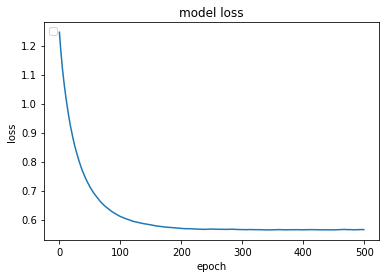

In [ ]:
plot_rmse(hist)

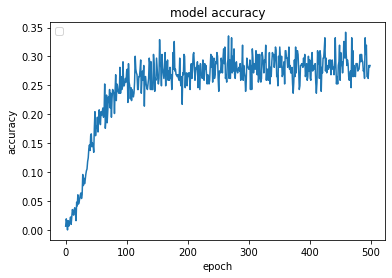

In [ ]:
plot_acc(hist)